# Mistral Biases Audit

This notebook is part of a project conducted by [names] that aims at studying the potential identity biasis of the brand new LLM model developed by Mistral, on a European scale

The notebook follows the work of data collection available [here](https://), and focuses on the exploitation of brut data to the final resutls

## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm

import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon

In [35]:
from google.colab import drive
drive.mount('/content/drive')

path_result = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/result/'

Mounted at /content/drive


## Preprocessing - Mistral's answers
- Creation of the dataset used for visualization of Mistral_EU, Mistral_US and Mistral_Neutral
- Creation of the dataset used for the regression comparing Mistral_US-Mistral_Neutral and Mistral_EU-Mistral_Neutral


In [36]:
# Import
path_brut_set1_2 = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/brut/final_result_mistral_questions.pkl'
path_brut_set3 = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/brut/final_result_mistral_questions_set_3.pkl'

data_brut_set1_2 = pd.read_pickle(path_brut_set1_2)
data_brut_set3 = pd.read_pickle(path_brut_set3)
data_brut = pd.concat([data_brut_set1_2, data_brut_set3])

In [ ]:
# Cleaning

def clean_score(score:str):
  """
  Score is cleaned by remove Mistral's outputs without number, and select the number of the output only
  if Mistral added useless text in its answer
  """
  try: #test if the score is already an integer (nothing to do)
    return int(score)
  except:
    figures = [int(i) for i in score.split() if i.isdigit()]
    if (len(figures) == 1) and (figures[0] in [i for i in range(11)]): #test if the score contains a single number in [0:10]
      result = figures[0]
    else:
      result = np.nan
    return result

def change_scale(row_id_set, row_result):
  """
  Questions from set 3 are graded between 1 and 6, the function change the scale into [0:10]
  allowing the regression between all sets of question
  """
  return (row_result - 1) * 10 / 5 if row_id_set == 3 else row_result

def change_round(row_id_set, row_round):
  """
  Questions from set 3 have rounds between 0 and 99, the function change the scale into [1:100]
  """
  return row_round + 1 if row_id_set == 3 else row_round

def stat_display(data: pd.DataFrame):

  df, df_clean = data, data.dropna()

  print(f"- - - - - - - - - - - - - DATASET- - - - - - - - - - - - -")
  print(f"The dataset adresses {len(df.id_country.unique())} different personnation which are {df.id_country.unique()}")
  print(f"It is supposed to contain {len(df.id_set.unique())} sets of respectively {[len(df[df.id_set==i].id_question.unique()) for i in df.id_set.unique().tolist()]} questions")
  for i in df.id_set.unique().tolist():
    print(f"------ Set {i} -------")
    print(f"=> {len(df[df.id_set==i].id_round.unique())} rounds performed")
    for q in df[df.id_set==i].id_question.sort_values().unique().tolist():
      nb_ask = len(df[(df.id_set==i) & (df.id_question==q)])
      nb_answer = len(df_clean[(df_clean.id_set==i) & (df_clean.id_question==q)])
      percentage = round(nb_answer/nb_ask, 2)*100
      print(f"==> Q{q} asked {len(df[(df.id_set==i) & (df.id_question==q)])} times ====> {percentage}% answered")
    print("------------------------")
  print("")

data_brut.output = data_brut.output.apply(clean_score) #Clean the answer and make non conventional answer NaN value
data_brut = data_brut.rename({'output': 'result'}, axis='columns') #change column name
data_brut.result= data_brut.apply(lambda row: change_scale(row.id_set, row.result), 1) # change scale for set_3
data_brut.id_round= data_brut.apply(lambda row: change_round(row.id_set, row.id_round), 1) # change rounds for set_3

stat_display(data_brut)
data_brut = data_brut.dropna()

- - - - - - - - - - - - - DATASET- - - - - - - - - - - - -
The dataset adresses 3 different personnation which are ['EU' 'NEUTRAL' 'US']
It is supposed to contain 3 sets of respectively [11, 12, 13] questions
------ Set 1 -------
=> 100 rounds performed
==> Q1 asked 15150 times ====> 100.0% answered
==> Q2 asked 15150 times ====> 100.0% answered
==> Q3 asked 15150 times ====> 100.0% answered
==> Q4 asked 15150 times ====> 100.0% answered
==> Q5 asked 15150 times ====> 100.0% answered
==> Q6 asked 15150 times ====> 100.0% answered
==> Q7 asked 15150 times ====> 100.0% answered
==> Q8 asked 15150 times ====> 100.0% answered
==> Q9 asked 15150 times ====> 100.0% answered
==> Q10 asked 15150 times ====> 100.0% answered
==> Q11 asked 15150 times ====> 99.0% answered
------------------------
------ Set 2 -------
=> 100 rounds performed
==> Q1 asked 15150 times ====> 98.0% answered
==> Q2 asked 15150 times ====> 97.0% answered
==> Q3 asked 15150 times ====> 92.0% answered
==> Q4 asked 15150 t

As we can see Q8 can be removed as only 5% of questions has been correctly answered

In [ ]:
# Update of question names
data_brut = data_brut[~((data_brut.id_set == 2) & (data_brut.id_question == 8))] # Remove Q8 of Set 2

# Transform the name of question to have in the set 2 question from 1 to 11
def replace(row_id_set, row_id_question):
  """
  Rename question between 1 to 12 without q8 to questions 1 to 11
  """
  return row_id_question -1 if ((row_id_set == 2) and (row_id_question > 8)) else row_id_question

data_brut.id_question = data_brut.apply(lambda row: replace(row.id_set, row.id_question), 1)
data_brut = data_brut.rename({'output': 'result'}, axis='columns') #change column name

#Save
path_brut_clean = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/final/final_result.csv'
data_brut.to_csv(path_brut_clean, index=False)

#### Creation of the dataset used for visualization of Mistral_EU, Mistral_US and Mistral_Neutral

=> Calculate the score of each round of each category (Neutral, US, EU) on the 2 dimensions (set1 and set2)

In [ ]:
# Calculation of the avg score
"""
There is no methodology to calcul a meaning score reflecting all questions,
 we decide to use a basic score that give the meaning score, without any ponderation
"""

df_viz = data_brut.groupby(
    ['id_country', 'id_round', 'id_set'], as_index=False
).result.mean()

In [ ]:
path_viz = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/final/result_mistral_viz.csv'
df_viz.to_csv(path_viz, index=False)

#### Creation of the dataset used for the regression comparing Mistral_US-Mistral_Neutral and Mistral_EU-Mistral_Neutral

=> Calculate the score each category (Neutral, US, EU) on the 2 dimensions (set1 and set2) for the regression

In [ ]:
# Apply the bootstrap mean calcul

def  bootstrap_mean(data: list, num_samples=1000)-> float:
  """
  Returns the estimated mean of a 1000 times boostrapped mean for each round
  https://www.askpython.com/python/examples/bootstrap-sampling-introduction
  """
  bootstrap_means = np.zeros(num_samples)

  # Perform bootstrap sampling
  for i in range(num_samples):
      bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
      bootstrap_mean = np.mean(bootstrap_sample)
      bootstrap_means[i] = bootstrap_mean

  estimated_mean = np.mean(bootstrap_means)

  return estimated_mean

df_bootstrap= data_brut.groupby(
    ['id_country', 'id_set', 'id_question'], as_index=False
).apply(
    lambda x: bootstrap_mean(x.result.tolist())
).rename(
    columns={None: "bootstrapped_result"}
)
df_bootstrap.head()

id_country  id_set  id_question  bootstrapped_result
0         EU       1            1                 10.0
1         EU       1            2                 10.0
2         EU       1            3                 10.0
3         EU       1            4                 10.0
4         EU       1            5                 10.0

In [ ]:
path_reg = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/final/result_mistral_reg.csv'
df_bootstrap.to_csv(path_reg, index=False)

## Preprocessing - EU survey's answers per country

In [ ]:
path_survey = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/brut/Data_on_survey_responses.xlsx'

#Only question T21 to T31 and T35 to T46 are used for this study
"""
T21 to T31 have score between 0 and 10, with the answer "don't know" (value -1)
T35 to T46 (without T42) have score between 0 and 10, with the answer "don't know" (value -1) and "not applicable" (value -2)
"""
set1 = ['T'+str(i) for i in range(21,32)] # EU values
set2 = ['T'+str(i) for i in range(35,47)] # Identity
set3 = ['T'+str(i) for i in range(5,18)] # Personnal values
set2.remove('T42') # remove T42 (q8)

sheet_names = set1 + set2 + set3
questions_dict = {key: i for (key,i) in zip(sheet_names, [k for k in range(1, len(set1) + 1)] + [k for k in range(1, len(set2) + 1)]+ [k for k in range(1, len(set3) + 1)]) }

In [ ]:
def change_scale1(row_id_set, row_score):
  """
  Questions from set 3 are graded between 1 and 6, the function change the scale into [0:10]
  allowing the regression between all sets of question
  """
  return (row_score - 1) * 10 / 5 if row_id_set == 3 else row_score

def clean_survey(sheet_name:str, path:str) -> pd.DataFrame:
  """
  Return a cleaned dataframe, organized as a SQL database
  """
  # Import
  df = pd.read_excel(path, sheet_name=sheet_name)

  # Different format for the 2 sets
  if sheet_name in ['T'+str(i) for i in range(21,32)]:
    id_set, shape_crop = 1, 33
    new_values = [i for i in range(0, 11)] + [-1] #-1 means people answer "don't know", -2 means "not applicable"
  elif sheet_name in ['T'+str(i) for i in range(35,47)]:
    id_set, shape_crop = 2, 35
    new_values = [i for i in range(0, 11)] + [-2, -1]
  else:
    id_set, shape_crop = 3, 24
    new_values = [i for i in range(1, 7)] + [-1] #-1 means people answer "don't know", -2 means "not applicable"

  #Cleaning
  df= df[7:shape_crop][
      (~df['Unnamed: 1'].isna()) | (df['Unnamed: 2'] == 'UE27 EU27')
  ].drop(['Unnamed: 0', 'Unnamed: 1'], axis=1)
  df.columns = df.iloc[0]
  df = df[2:]

  df.insert(loc=0, column='score', value=new_values) #new names for scores of question
  df.insert(loc=0,column='id_question',value=sheet_name) #add the question number
  df.insert(loc=0, column='id_set', value=id_set) #id of the group of question
  df = df.melt(id_vars=['id_set','id_question', 'score'], var_name='id_country') #pivot to have the SGL standard
  df['id_country'] = df['id_country'].replace({'UE27 EU27': 'EU27'}) # Replace ugly name
  df.score = df.apply(lambda row: change_scale1(row.id_set, row.score), 1) # change scale for set_3

  #New column - percentage of answering
  df.value = df.value.replace('-', '0')
  df.value = df.value.astype(int)
  df['percentage'] = df.value / df.groupby(['id_country', 'id_set', 'id_question']).value.transform('sum')

  return df


def brut_survey(path:str, sets=[set1, set2, set3]) -> pd.DataFrame:
  """
  Returns a big dataframe with all reponses of the survey, cleaning, in SQL standard
  """
  first = True
  set1, set2, set3 = sets[0], sets[1], sets[2]
  sheet_names = set1 + set2 + set3
  questions_dict = {key: i for (key,i) in zip(sheet_names, [k for k in range(1, len(set1)+1)] + [k for k in range(1, len(set2)+1)] + [k for k in range(1, len(set3)+1)]) }

  for sheet_name in sheet_names:
    print(sheet_name)
    if first:
      df = clean_survey(sheet_name, path)
      first = False
    else:
      df = pd.concat([df, clean_survey(sheet_name, path)])

  df['id_question'] = df['id_question'].replace(questions_dict) # Question names
  df = df[df.score >= 0] #Remove "don't know" and "not applicable" answers

  return df

In [ ]:
#%%capture
survey_clean = brut_survey(path_survey)

In [ ]:
# Save
path_save = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/final/survey_clean.csv'
survey_clean.to_csv(path_save, index=False)

## Analysis

In [ ]:
# Import
path_brut = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/final/final_result.csv'
path_reg = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/final/result_mistral_reg.csv'
path_viz = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/final/result_mistral_viz.csv'
path_survey = '/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/final/survey_clean.csv'

df_brut = pd.read_csv(path_brut)
df_reg = pd.read_csv(path_reg)
df_viz = pd.read_csv(path_viz)
df_survey = pd.read_csv(path_survey)

### Is Mistral european or american biased?

#### Data Visualization

##### Boxplot

In [ ]:
# Boxplots

# Change the shape for ploting
df_brut2 = df_brut.pivot_table('result', ['id_country','id_round','id_set'], 'id_question').reset_index()
df_brut2.columns = df_brut2.columns.rename('')

# Plot per question
def boxplot(df:pd.DataFrame, id_set:int, title:str, figsize=None, real_scale=False):

  ax = df[df.id_set == id_set].drop(['id_round', 'id_set'], axis=1).plot.box(
      by='id_country',
      figsize=figsize,
      grid=True,
      title=title,
      ylim = (0, 10) if real_scale else None
  )

  return df[df.id_set == id_set].drop(['id_round', 'id_set'], axis=1).describe()


def stats(df:pd.DataFrame, id_set:int):

  return df[df.id_set == id_set].drop(['id_round', 'id_set'], axis=1).groupby(['id_country']).describe().transpose()

In [ ]:
#Save results

for i in [1,2,3]:
  stats(df=df_brut2, id_set=i).to_csv(f'/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/result/boxplot_set{i}.csv')

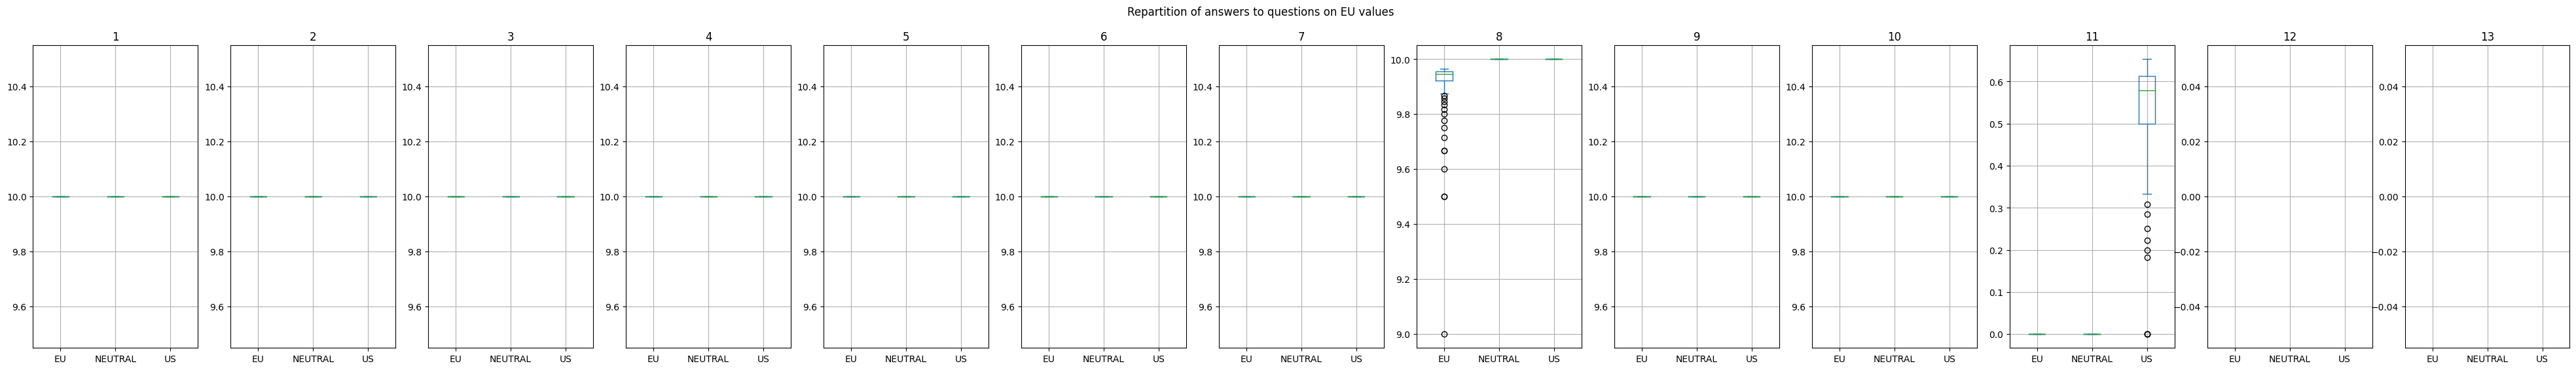

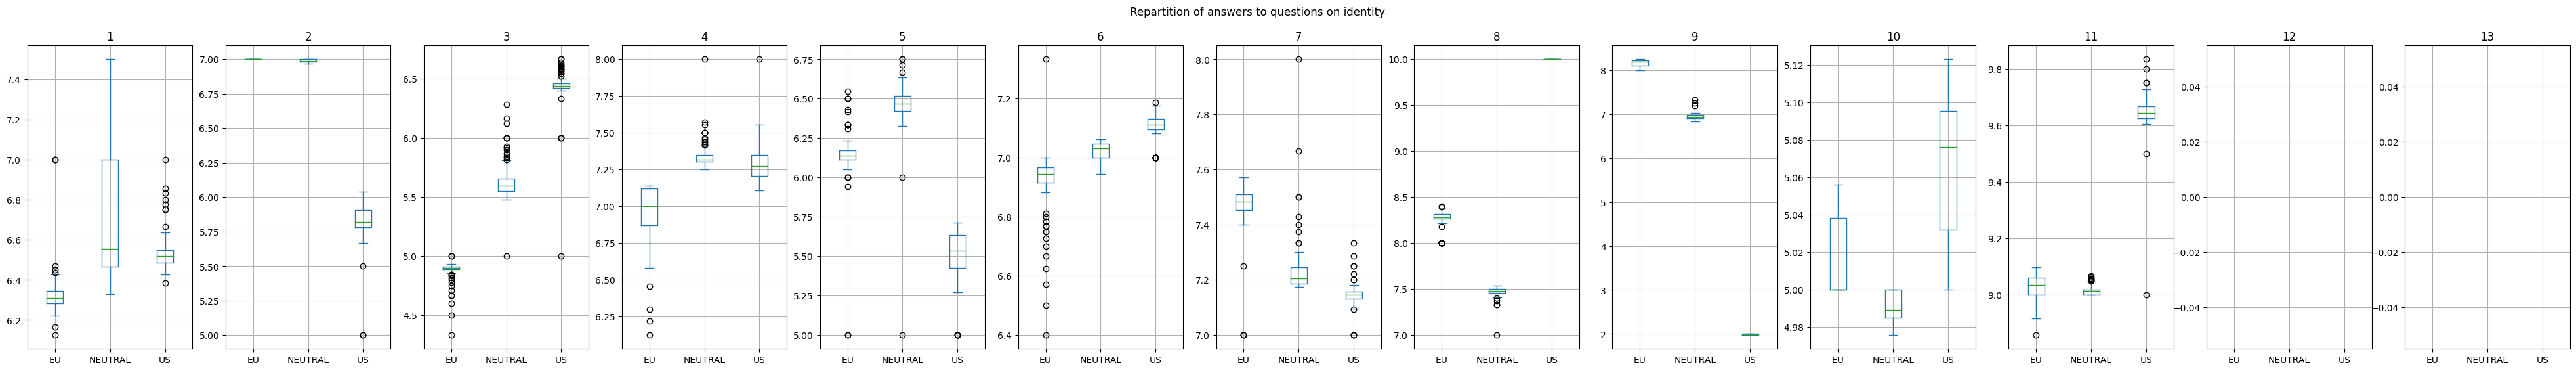

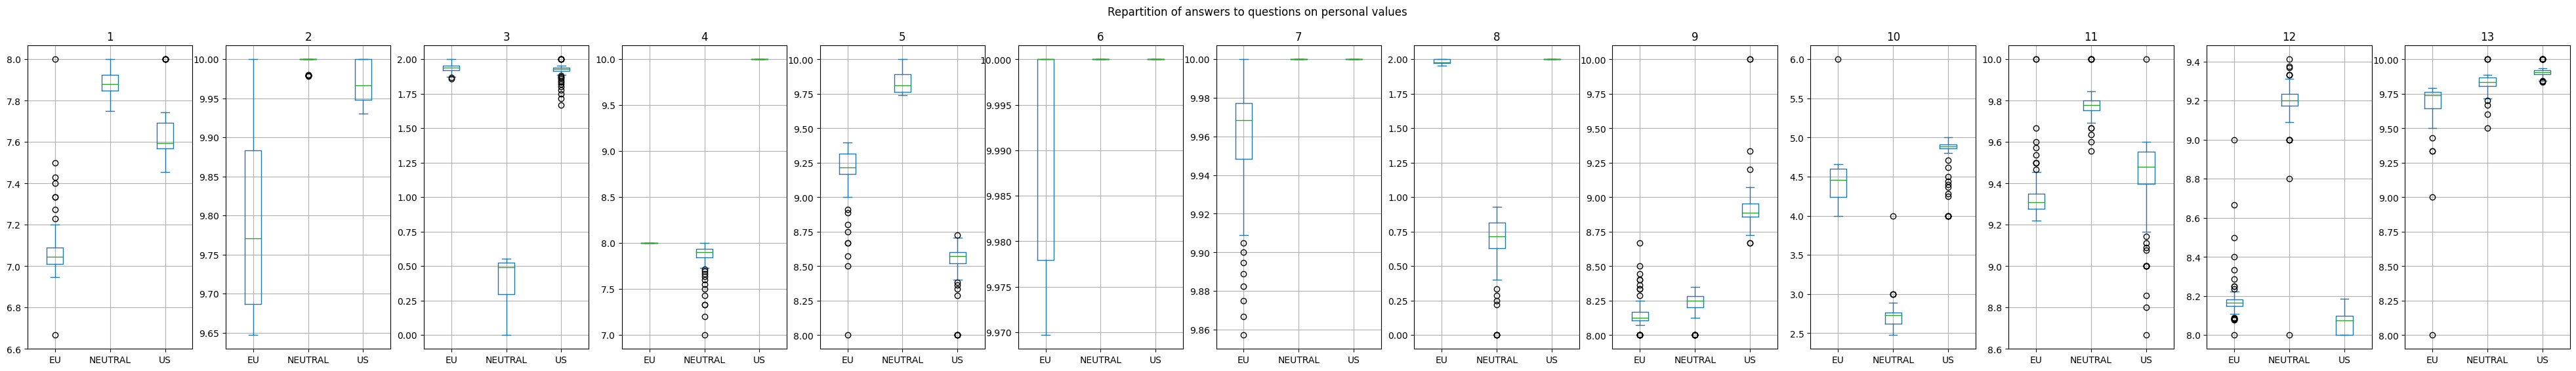

In [ ]:
# Adjusted scales
boxplot(df=df_brut2, id_set=1, title='Repartition of answers to questions on EU values', figsize=(50,6))
boxplot(df=df_brut2, id_set=2, title='Repartition of answers to questions on identity', figsize=(50,6))
boxplot(df=df_brut2, id_set=3, title='Repartition of answers to questions on personal values', figsize=(50,6))

plt.savefig(path_result + 'boxplot_allquestions.png')

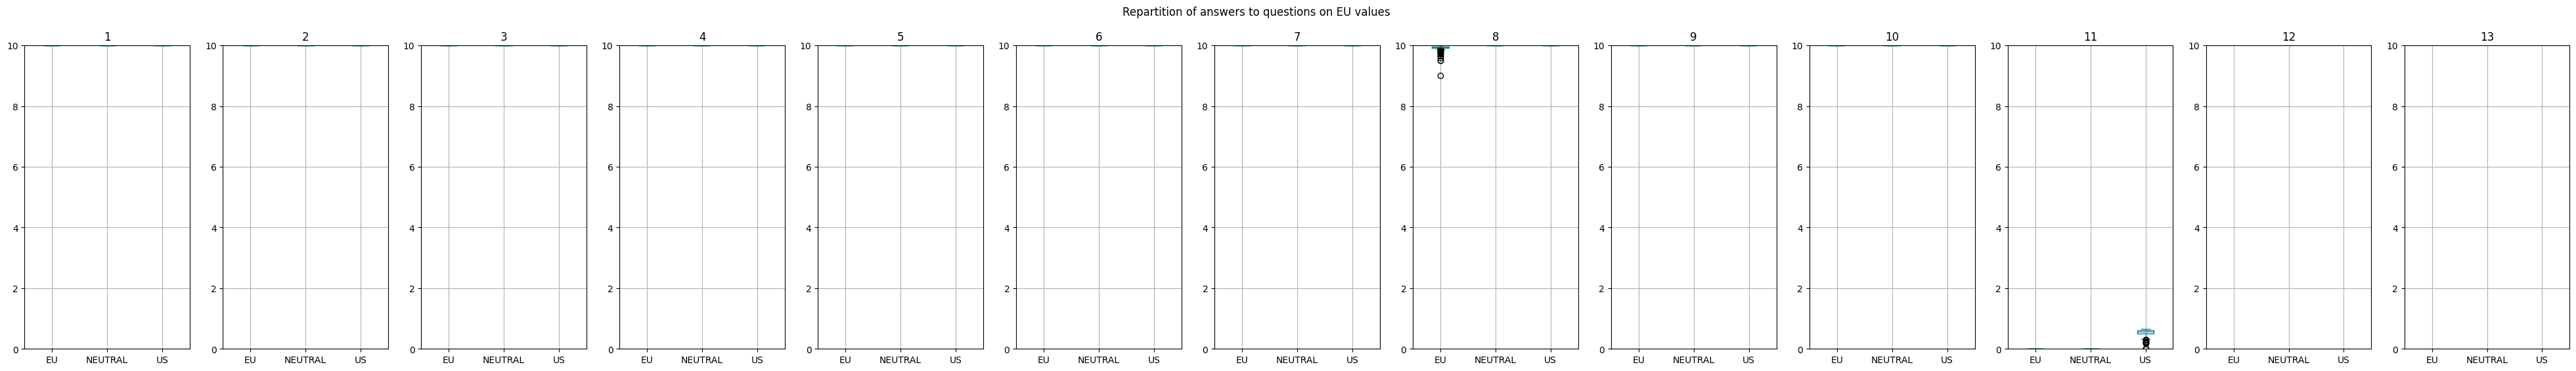

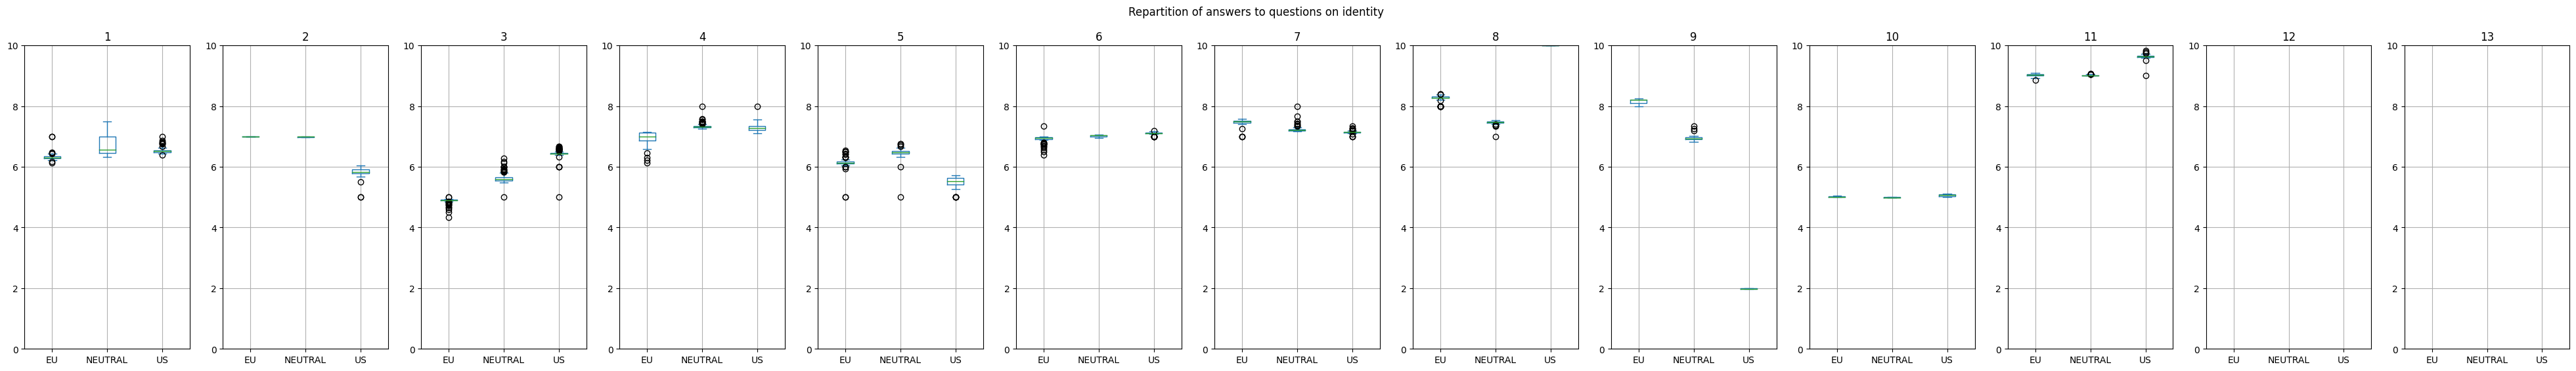

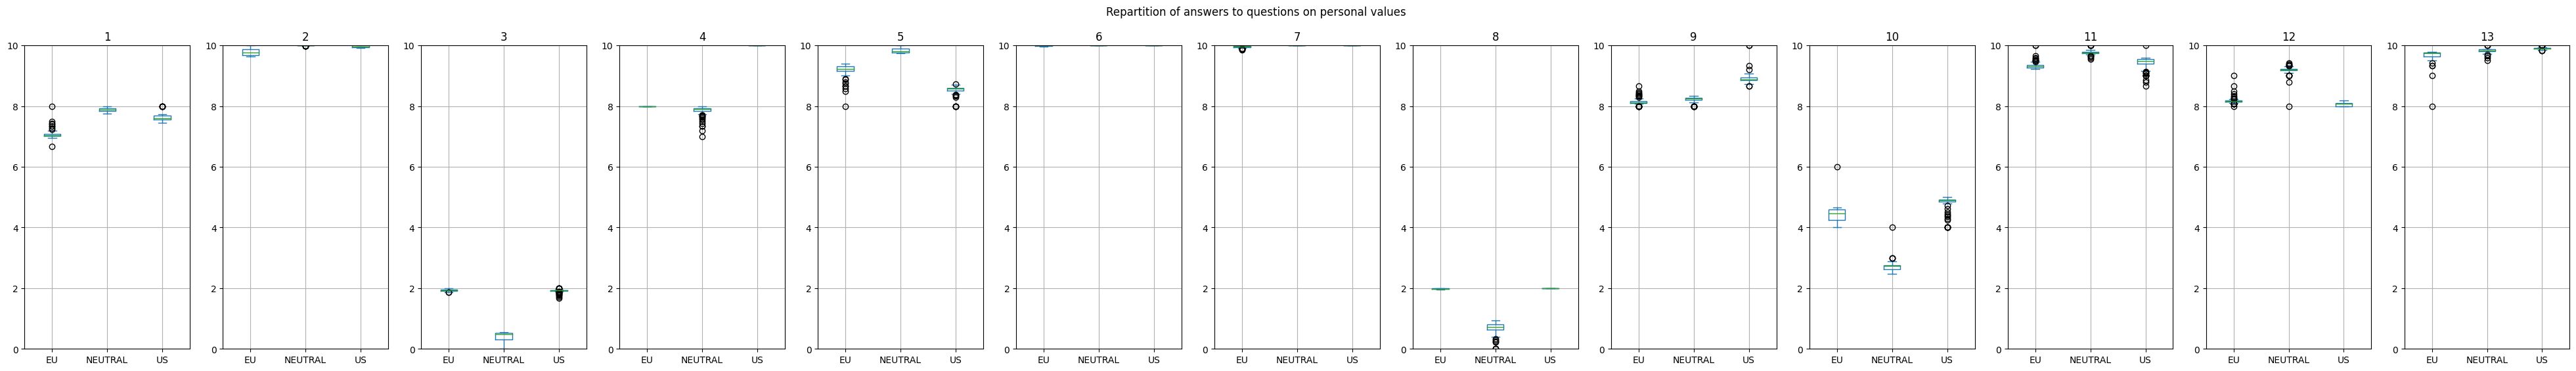

In [ ]:
# Real scales from 0 to 10
boxplot(df=df_brut2, id_set=1, title='Repartition of answers to questions on EU values', figsize=(50,6), real_scale=True)
boxplot(df=df_brut2, id_set=2, title='Repartition of answers to questions on identity', figsize=(50,6), real_scale=True)
boxplot(df=df_brut2, id_set=3, title='Repartition of answers to questions on personal values', figsize=(50,6), real_scale=True)

#plt.savefig(path_result + 'boxplot_allquestions_V2.png')

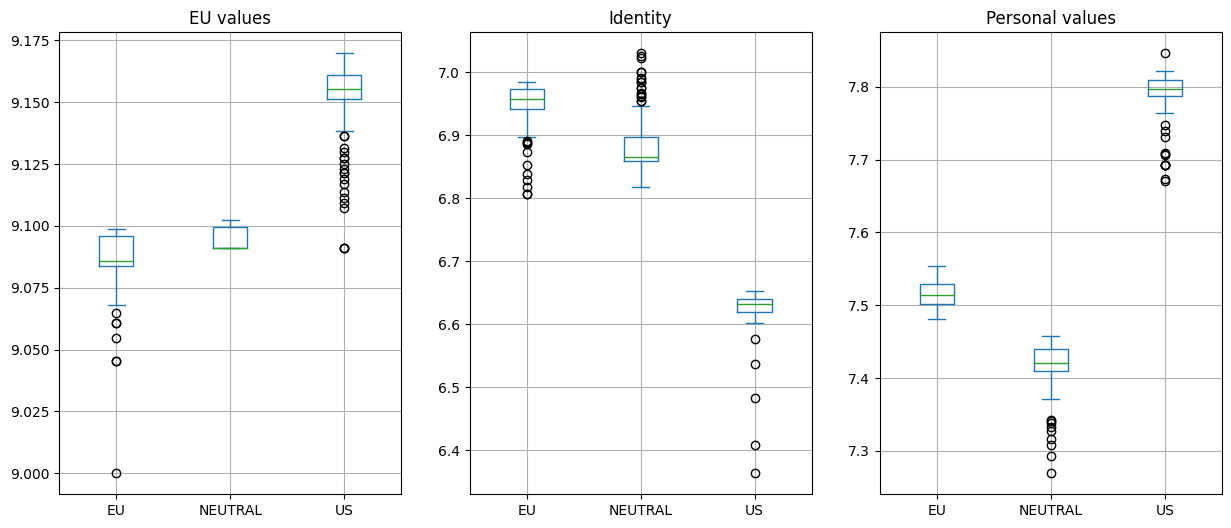

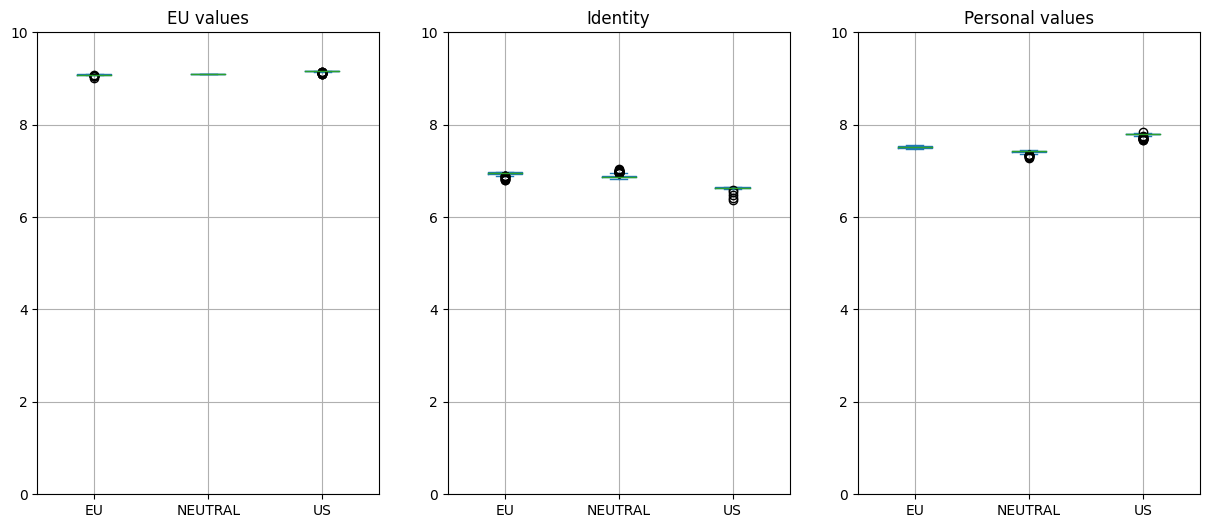

In [ ]:
# Boxplots by dimension

# Change the shape for ploting
df_viz2 = df_viz.pivot_table('result', ['id_country','id_round'], 'id_set').reset_index()
df_viz2.columns = df_viz2.columns.rename('')
df_viz2 = df_viz2.rename(columns={1: 'EU values', 2: 'Identity', 3:'Personal values'})
df_viz2 =df_viz2.drop(['id_round'], axis=1)

# Plot per question
ax_adjusted_scale = df_viz2.plot.box(by='id_country', figsize=(15,6), grid=True)
ax_real_scale = df_viz2.plot.box(by='id_country', figsize=(15,6), grid=True, ylim = (0, 10))

#To save
#plt.savefig(path_result + 'boxplot_dimensions.png')

In [ ]:
df_viz2.groupby(['id_country']).describe().transpose()

id_country                     EU     NEUTRAL          US
                                                         
EU values       count  100.000000  100.000000  100.000000
                mean     9.085374    9.093611    9.149874
                std      0.013747    0.004381    0.017883
                min      9.000000    9.090909    9.090909
                25%      9.083846    9.090909    9.151334
                50%      9.086017    9.090909    9.155548
                75%      9.095851    9.099372    9.161061
                max      9.098945    9.102244    9.169811
Identity        count  100.000000  100.000000  100.000000
                mean     6.945857    6.889733    6.623460
                std      0.039789    0.048491    0.040443
                min      6.806452    6.818182    6.363636
                25%      6.941097    6.859076    6.620423
                50%      6.957582    6.866172    6.632291
                75%      6.973402    6.897135    6.640706
                max      6.984419    7.030303    6.652542
Personal values count  100.000000  100.000000  100.000000
                mean     7.514481    7.414959    7.788686
                std      0.017056    0.036528    0.034509
                min      7.481319    7.269231    7.670330
                25%      7.501388    7.409299    7.787750
                50%      7.514106    7.420370    7.797666
                75%      7.529438    7.440607    7.808763
                max      7.553846    7.458462    7.846154

#### Scatter Plot

##### 3 dimensions

In [ ]:
# Plot 3D for the 3 dimensions
def plot_3D(df:pd.DataFrame, adjusted_scale=True):
  fig = px.scatter_3d(df, x='EU values', y='Identity', z='Personal values',color='id_country')
  if not adjusted_scale:
    fig.update_layout(autosize=False,
                      height=600,
                      width=600,
                      scene=dict(
                          xaxis = dict(nticks=6, range=[0,10],),
                          yaxis = dict(nticks=6, range=[0,10],),
                          zaxis = dict(nticks=6, range=[0,10],)
                      )
                    )
  fig.show()

In [ ]:
plot_3D(df_viz2, adjusted_scale=False)

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_3D(df_viz2)

##### 2 dimensions

In [ ]:
# Vizualization of all position of the 2 axis

def plot_2d(df: pd.DataFrame, axis_x:str, axis_y:str, name=None, adjusted_scale=True):
  fig, ax = plt.subplots()
  ax.plot(df[df.id_country == 'US'][axis_x], df[df.id_country == 'US'][axis_y], marker='d', color='g', linestyle='', ms=5, label='Mistral_US')
  ax.plot(df[df.id_country == 'EU'][axis_x], df[df.id_country == 'EU'][axis_y], marker='^', color='b', linestyle='', ms=5, label='Mistral_EU')
  ax.plot(df[df.id_country == 'NEUTRAL'][axis_x], df[df.id_country == 'NEUTRAL'][axis_y], marker='o', color='r', linestyle='', ms=5, label='Mistral_Neutral')

  if not adjusted_scale:
    plt.xticks([i for i in range(11)])
    plt.yticks([i for i in range(11)])
  plt.title(f'Comparison on the {axis_x} and {axis_y} scores of different impersonation of Mistral')
  plt.xlabel(axis_x)
  plt.ylabel(axis_y)
  ax.legend()
  plt.grid()
  plt.show()

  if name:
    plt.savefig(name)

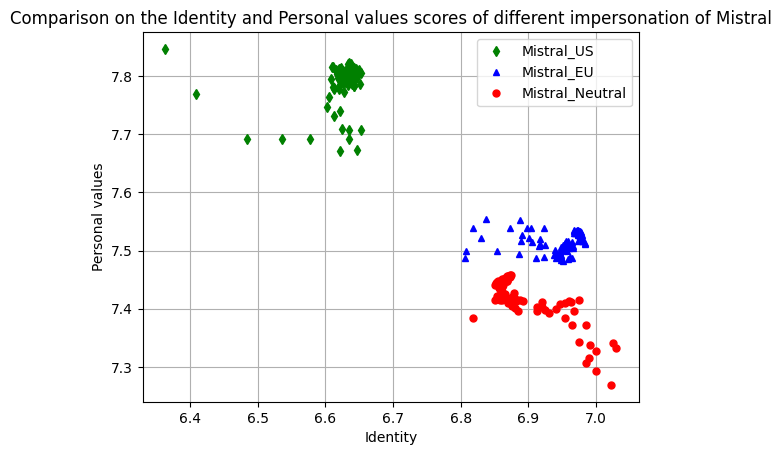

In [ ]:
#Choose axis among 'EU values', 'Identity', and 'Personal values'
plot_2d(df_viz2, axis_x='Identity', axis_y='Personal values', adjusted_scale=True)

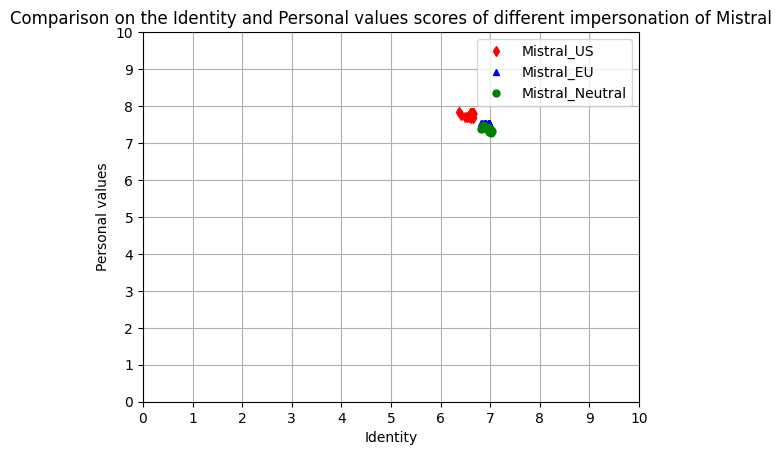

In [ ]:
# Same with another scale
plot_2d(df_viz2, axis_x='Identity', axis_y='Personal values', adjusted_scale=False)

#### Regression




In [ ]:
def RegLin(imp:str, data:pd.DataFrame, name_LR:str):

  X = np.array(data[imp].tolist()).reshape((-1, 1))
  y = np.array(data['NEUTRAL'].tolist()).reshape((-1, 1))

  X = sm.add_constant(X)
  results = sm.OLS(y, X).fit()

  # Latex
  latex_file = '\\documentclass{article} \n\\usepackage{graphicx} \n\\usepackage{booktabs} \n\\title{bias}\n\\author{Anthony Ammendolea}\n\\date{April 2024}\n\\begin{document}\n'
  for table in results.summary().tables:
    latex_file += table.as_latex_tabular()
  latex_file += '\n\\end{document}'
  # Save
  path = f'/content/drive/Shareddrives/(NP)SP24M1S2-DecodingAIBiases_GProject/Data/result/LR_{name_LR}.txt'
  text_file = open(path, "w")
  text_file.write(latex_file)
  text_file.close()

  return latex_file, results.summary()

##### Regression for all questions

Linear regression of the equation $NeutralMistral_i = \beta_0 + \beta_1 . ImpMistral_i $ where $ImpMistral $ is either $Mistral{EU}$ or $Mistral{US}$ and where each $i$ is the 1000-times bootstrapped mean of a question

In [ ]:
# Regression with the 3 dimensions

# Reshape the df for the regression
df_reg2 = df_reg.copy()
df_reg2['id_question'] = df_reg2['id_set'].astype(str)  + pd.Series(['_' for i in range(len(df_reg2))]) + df_reg2['id_question'].astype(str)
df_reg2 = df_reg2.pivot_table('bootstrapped_result', ['id_question'], 'id_country').reset_index(drop=True)

latex_file_US, result_US = RegLin(imp='US', data=df_reg2, name_LR='3dim_US')
latex_file_EU, result_EU = RegLin(imp='EU', data=df_reg2, name_LR='3dim_EU')
print(result_US)
print(result_EU)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     158.9
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           3.65e-14
Time:                        13:36:01   Log-Likelihood:                -55.678
No. Observations:                  35   AIC:                             115.4
Df Residuals:                      33   BIC:                             118.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3976      0.621      0.640      0.5

In [ ]:
# Regression with the 2 dimensions => without EU values

df_reg3 = df_reg[df_reg.id_set.isin([2,3])].reset_index(drop=True).copy()
df_reg3['id_question'] = df_reg3['id_set'].astype(str)  + pd.Series(['_' for i in range(len(df_reg3))]) + df_reg3['id_question'].astype(str)
df_reg3 = df_reg3.pivot_table('bootstrapped_result', ['id_question'], 'id_country').reset_index(drop=True)

latex_file_US, result_US = RegLin(imp='US', data=df_reg3, name_LR='2dim_US')
latex_file_EU, result_EU = RegLin(imp='EU', data=df_reg3, name_LR='2dim_EU')
print(result_US)
print(result_EU)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     56.49
Date:                Sun, 28 Apr 2024   Prob (F-statistic):           1.64e-07
Time:                        13:38:45   Log-Likelihood:                -42.172
No. Observations:                  24   AIC:                             88.34
Df Residuals:                      22   BIC:                             90.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8808      0.889      0.991      0.3

##### Regression for the 2 dimensions

Linear regression of the equation $NeutralMistral_i = \beta_0 + \beta_1 . ImpMistral_i $ where $ImpMistral $ is either $Mistral{EU}$ or $Mistral{US}$ and where each $i \in \{value, identity\}$ is the means of the 1000-times bootstrapped mean per question of each dimension

In [ ]:
# Calculation of the avg score for each dimension
"""
There is no methodology to calcul a meaning score reflecting all questions,
 we decide to use a basic score that give the meaning score, without any ponderation
"""
df_reg4 = df_reg.copy()
df_reg4= df_reg4.groupby(
    ['id_country', 'id_set'], as_index=False
).bootstrapped_result.mean().rename(
    columns={'bootstrapped_result': 'final'}
)

# Reshape the df for the regression
df_reg4 = df_reg4.pivot_table('final', ['id_set'], 'id_country').reset_index(drop=True)

In [ ]:
latex_file_US, result_US = RegLin(imp='US', data=df_reg4, name_LR='perdim_US')
latex_file_EU, result_EU = RegLin(imp='EU', data=df_reg4, name_LR='perdim_EU')
print(result_US)
print(result_EU)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     16.15
Date:                Sun, 28 Apr 2024   Prob (F-statistic):              0.155
Time:                        13:40:31   Log-Likelihood:                0.18160
No. Observations:                   3   AIC:                             3.637
Df Residuals:                       1   BIC:                             1.834
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8986      1.732      0.519      0.6

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


### Is Mistral more or less similar to an European Country?

In this section, we are going to compare the results of the survey conduct by Mistral (neutral) to the real results of each european country

#### Preprocessing

In [ ]:
# Reshape brut for percentage
df_mistral_final = df_reg [df_reg .id_country == 'NEUTRAL']
df_mistral_final = df_mistral_final.groupby(
    ['id_country', 'id_set', 'id_question'],
    as_index=False
).bootstrapped_result.value_counts()
df_mistral_final

# Fill missing values
default = { key: [] for key in df_mistral_final.columns.tolist()}
for i in [1, 2, 3]:

  questions_list = df_survey[df_survey.id_set == i].id_question.unique().tolist()
  questions_done = df_mistral_final[df_mistral_final.id_set == i].id_question.unique().tolist()

  for k in questions_list:
    score_done = df_mistral_final[(df_mistral_final.id_set==i) & (df_mistral_final.id_question==k)].bootstrapped_result.unique().tolist()
    if k not in questions_done:
      for s in range(11):
        default['id_country'].append('NEUTRAL')
        default['id_set'].append(i)
        default['id_question'].append(k)
        default['bootstrapped_result'].append(s)
        default['count'].append(0)
    else:
      for s in range(11):
        if s not in score_done:
          default['id_country'].append('NEUTRAL')
          default['id_set'].append(i)
          default['id_question'].append(k)
          default['bootstrapped_result'].append(s)
          default['count'].append(0)
default = pd.DataFrame(default)
df_mistral_final = pd.concat([df_mistral_final, default])
df_mistral_final = df_mistral_final.sort_values(by=['id_country', 'id_set', 'id_question','bootstrapped_result'])

# Calcul percentage
df_mistral_final['percentage'] = df_mistral_final['count'] / df_mistral_final.groupby(['id_country', 'id_set', 'id_question'])['count'].transform('sum')

# Concat percentages
countries = df_survey.id_country.unique().tolist()
df_pc = df_survey[df_survey.id_country == 'FR'][['id_set', 'id_question', 'score']].copy().reset_index(drop=True)

for c in countries:
  df_pc[c] = df_survey[df_survey.id_country == c].percentage.reset_index(drop=True)
df_pc['Mistral'] = df_mistral_final.percentage.reset_index(drop=True)

str_ = ['_' for i in range(len(df_pc))] # Change indexes
q_name = (df_pc.id_set.astype(str).reset_index(drop=True) + pd.Series(str_) + df_pc.id_question.astype(str).reset_index(drop=True)  + pd.Series(str_) + df_pc.score.astype(str).reset_index(drop=True)).unique().tolist()
df_pc.index = q_name

#Calcul mean score
df_map = df_pc.copy()
for c in countries:
  df_map[c] = df_map[c] * df_map.score

df_map = df_map.drop(['score'], axis=1)
df_map = df_map.groupby(by=['id_set', 'id_question'], as_index=False).sum()


# Score similarity
df_map_question = df_map.copy() #similarity value for each question

df_map_set = df_map.drop(['id_question'], axis=1).copy()
df_map_set = df_map_set.groupby(by=['id_set'], as_index=False).mean() #similarity value for each set
for c in countries:
  df_map_question[c] = abs(abs(df_map_question[c] - df_map_question['Mistral']) - 10)/10 # 0 means the 2 values are completly opposed, 1 means they are the same
  df_map_set[c] = abs(abs(df_map_set[c] - df_map_set['Mistral']) - 10)/10

df_map_set = df_map_set.drop(['id_set', 'EU27', 'Mistral', 'D-E', 'D-W'], axis=True).transpose().sort_index().reset_index() #'D-E', 'D-W' unknown
df_map_set.rename(columns = {'index':'id_country'}, inplace = True)
df_map_question = df_map_question.drop(['id_set', 'EU27', 'Mistral', 'D-E', 'D-W'], axis=True).transpose().sort_index().reset_index() #'D-E', 'D-W' unknown
df_map_question.rename(columns = {'index':'id_country'}, inplace = True)

df_map_set.head() # percentage for each score/question/country

id_country         0         1         2
0         AT  0.276385  0.370920  0.416817
1         BE  0.342143  0.493912  0.435909
2         BG  0.294922  0.328856  0.303146
3         CY  0.261049  0.324045  0.308824
4         CZ  0.361514  0.399168  0.429424

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe=world[world.continent=="Europe"]
europe=europe[(europe.name!="Russia") & (europe.name!="Iceland")]

# Create a custom polygon
polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)])
"""
#https://towardsdatascience.com/geoplotting-emissions-intensity-of-electricity-generation-in-europe-90c22b378858
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
fig,ax=plt.subplots()
ax=europe.plot(ax=ax)
poly_gdf.plot(edgecolor="red",ax=ax, alpha=0.1)
plt.show()
"""
#Clip polygon from the map of Europe
europe=gpd.clip(europe, polygon)  #europe.plot()

# Add the data
#No Chypre, Malta 26
dict_EU = {'FRA':'FR', 'PRT':'PT', 'ESP':'ES', 'EST':'EE', 'ITA':'IT', 'HRV':'HR', 'SVN':'SI', 'SVK':'SK', 'AUT':'AT', 'LUX':'LU', 'BGR':'BG', 'ROU':'RO', 'HUN':'HU', 'POL':'PL', 'LTU':'LT', 'LVA':'LV', 'FIN':'FI', 'CZE':'CZ', 'BEL':'BE', 'DEU':'DE', 'NLD':'NL', 'IRL':'IE', 'DNK':'DK', 'SWE':'SE', 'GRC':'EL' }
europe['id_country'] = europe.iso_a3
europe.id_country= europe.id_country.replace(dict_EU)
europe = pd.merge(left=europe, right=df_map_set, on='id_country', how="left")
europe = europe.rename(columns={0: "EU values", 1: "Identity", 2: "Personal values"})

europe = pd.merge(left=europe, right=df_map_question, on='id_country', how="left")
dict_question = {0:'1_1', 1:'1_2',3:'1_3', 4:'1_4', 5:'1_5', 6:'1_6', 7:'1_7', 8:'1_8', 9:'1_9', 10:'1_10', 11:'1_11', 12:'2_1', 13:'2_2',14:'2_3', 15:'2_4', 16:'2_5', 17:'2_6', 18:'2_7', 19:'2_8', 20:'2_9', 21:'2_10', 22:'2_11'}
europe = europe.rename(columns=dict_question)

europe

<ipython-input-59-47e688974fee>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


pop_est continent              name iso_a3  gdp_md_est  \
0   67059887.0    Europe            France    FRA     2715518   
1   10269417.0    Europe          Portugal    PRT      238785   
2   47076781.0    Europe             Spain    ESP     1393490   
3   60297396.0    Europe             Italy    ITA     2003576   
4    3301000.0    Europe  Bosnia and Herz.    BIH       20164   
5    4067500.0    Europe           Croatia    HRV       60752   
6    2087946.0    Europe          Slovenia    SVN       54174   
7    8574832.0    Europe       Switzerland    CHE      703082   
8    8877067.0    Europe           Austria    AUT      445075   
9     619896.0    Europe        Luxembourg    LUX       71104   
10  10716322.0    Europe            Greece    GRC      209852   
11   2854191.0    Europe           Albania    ALB       15279   
12   2083459.0    Europe   North Macedonia    MKD       12547   
13   1794248.0    Europe            Kosovo    -99        7926   
14    622137.0    Europe        Montenegro    MNE        5542   
15   6975761.0    Europe          Bulgaria    BGR       68558   
16   6944975.0    Europe            Serbia    SRB       51475   
17  19356544.0    Europe           Romania    ROU      250077   
18   2657637.0    Europe           Moldova    MDA       11968   
19   9769949.0    Europe           Hungary    HUN      163469   
20  44385155.0    Europe           Ukraine    UKR      153781   
21   5454073.0    Europe          Slovakia    SVK      105079   
22  37970874.0    Europe            Poland    POL      595858   
23   9466856.0    Europe           Belarus    BLR       63080   
24   2786844.0    Europe         Lithuania    LTU       54627   
25   1912789.0    Europe            Latvia    LVA       34102   
26   1326590.0    Europe           Estonia    EST       31471   
27   5520314.0    Europe           Finland    FIN      269296   
28  10669709.0    Europe           Czechia    CZE      250680   
29  11484055.0    Europe           Belgium    BEL      533097   
30  83132799.0    Europe           Germany    DEU     3861123   
31  17332850.0    Europe       Netherlands    NLD      907050   
32   4941444.0    Europe           Ireland    IRL      388698   
33  66834405.0    Europe    United Kingdom    GBR     2829108   
34   5818553.0    Europe           Denmark    DNK      350104   
35  10285453.0    Europe            Sweden    SWE      530883   
36   5347896.0    Europe            Norway    NOR      403336   

                                             geometry id_country  EU values  \
0   MULTIPOLYGON (((6.65823 49.20196, 8.09928 49.0...         FR   0.303506   
1   POLYGON ((-8.67195 42.13469, -8.26386 42.28047...         PT   0.262581   
2   POLYGON ((-7.53711 37.42890, -7.16651 37.80389...         ES   0.252165   
3   MULTIPOLYGON (((11.04856 46.75136, 11.16483 46...         IT   0.382451   
4   POLYGON ((17.67492 43.02856, 17.29737 43.44634...        BIH        NaN   
5   POLYGON ((16.88252 46.38063, 17.63007 45.95177...         HR   0.270280   
6   POLYGON ((14.63247 46.43182, 15.13709 46.65870...         SI   0.335218   
7   POLYGON ((9.63293 47.34760, 9.47997 47.10281, ...        CHE        NaN   
8   POLYGON ((16.90375 47.71487, 16.34058 47.71290...         AT   0.276385   
9   POLYGON ((6.24275 49.90223, 6.18632 49.46380, ...         LU   0.341285   
10  MULTIPOLYGON (((26.16500 35.00500, 26.08038 35...         EL   0.261624   
11  POLYGON ((20.99999 40.58000, 20.67500 40.43500...        ALB        NaN   
12  POLYGON ((22.88137 41.99930, 22.95238 41.33799...        MKD        NaN   
13  POLYGON ((20.52295 42.21787, 20.28375 42.32026...        -99        NaN   
14  POLYGON ((19.80161 42.50009, 19.73805 42.68825...        MNE        NaN   
15  POLYGON ((22.94483 43.82379, 23.33230 43.89701...         BG   0.294922   
16  POLYGON ((18.82984 45.90888, 19.59604 46.17173...        SRB        NaN   
17  POLYGON ((28.67978 45.30403, 29.14972 45.46493...         RO   0.392241   
18  POLYGON ((26.85782 48.36821, 27

In [ ]:
len(europe[europe.Identity<0.4])

11

#### Map


In [ ]:
# Plot Function
def plot_map(enter:str, title:str):
  fig, ax = plt.subplots(1, 1)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("bottom", size="10%", pad=0.1)

  ax = europe.plot(
      column=enter,
      figsize=(20,20),
      cmap='Blues', #https://matplotlib.org/stable/users/explain/colors/colormaps.html 'OrRd'
      ax=ax,
      legend=True,
      cax=cax,
      vmin=0,
      vmax=1,
      legend_kwds={
          "label": title,
          "orientation": "horizontal",
      },
      missing_kwds={
          "color": "lightgrey",
          "edgecolor": "red",
          "hatch": "///",
          "label": "Missing values",
      }
  )
  ax.set_axis_off()

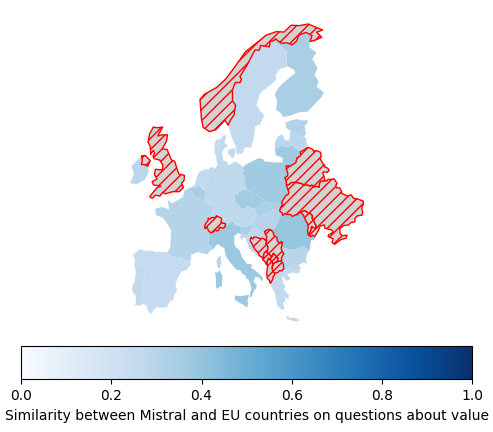

In [ ]:
plot_map(enter='EU values', title='Similarity between Mistral and EU countries on questions about value')

#to save
#plt.savefig(path_result + 'map_similarity_EUValues.png')

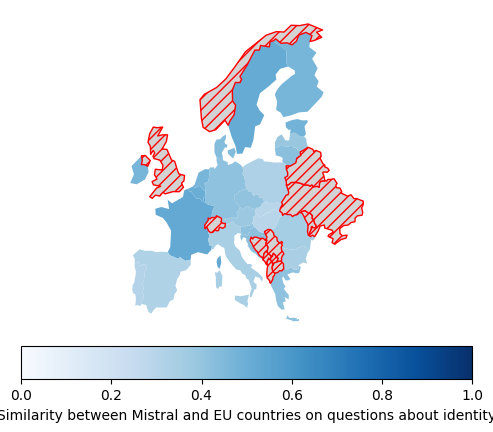

In [ ]:
plot_map(enter='Identity', title='Similarity between Mistral and EU countries on questions about identity')

#to save
#plt.savefig(path_result + 'map_similarity_Identity.png')

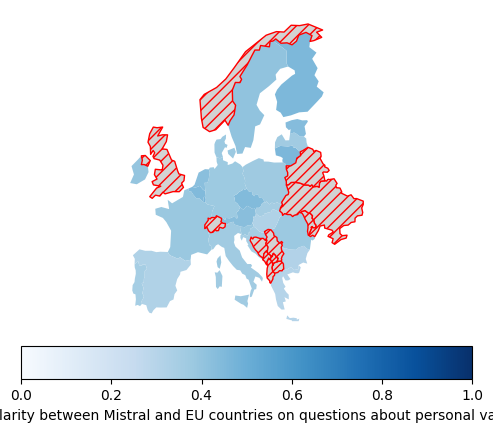

In [ ]:
plot_map(enter='Personal values', title='Similarity between Mistral and EU countries on questions about personal values')

#to save
#plt.savefig(path_result + 'map_similarity_PersonalValues.png')